In [2]:
%cd ..

/home/seb/Perso/git/sudoku/sudoku_clean_v2


In [3]:
import torch
import pytorch_lightning as pl
from torch import nn
import torch.nn.functional as F
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sudoku.models import SmallNetBis, SymPreprocess
from sudoku.loader import DataIterBuffer, train_dataset, test_dataset, data_loader, get_datasets
from sudoku.helper import display_as_dataframe

from collections import deque
from typing import Tuple


from torchmetrics import AUROC
from torch.utils.data.dataset import IterableDataset
from torch.utils.data import  DataLoader

from pytorch_lightning.callbacks import ModelCheckpoint
from lightning_lite.utilities.seed import seed_everything

import numpy as np


import math
def sigmoid(x):
    return 1 / (1 + math.exp(-x))



In [4]:
torch.cuda.is_available()
tensorboard = pl.loggers.TensorBoardLogger(save_dir="")

In [5]:
seed_everything(seed=1)

Global seed set to 1


1

In [6]:
train_dataset, test_dataset = get_datasets(train_size=1280, test_size=1280)

In [7]:
test_x, test_y = tuple(next(iter(data_loader(batch_size=1)[1])))

In [8]:
def transform_to_number_1(input_tensor):
    tensor = input_tensor.reshape(input_tensor.shape[0], 2, 9, 9, 9)
    max_value, chiffre_tensor = torch.max(tensor[:,1,:,:,:],-1)
    chiffre_tensor = chiffre_tensor+1
    return chiffre_tensor

def transform_to_number_0(input_tensor):
    tensor = input_tensor.reshape(input_tensor.shape[0], 2, 9, 9, 9)
    max_value, chiffre_tensor = torch.min(tensor[:,0,:,:,:],-1)
    chiffre_tensor = chiffre_tensor+1
    return chiffre_tensor

In [9]:
torch.sigmoid(torch.tensor(4))

tensor(0.9820)

- test clip -4 4: ne fonctionne  pas
- analyse des distributions:
- la recherches des absent marche : beaucoup d'exemple dans la data.
- la recherche des present est disfonctionel: très très peu d'exemple

idée:
- entrainer la recherche des present seulement sur le second tour et plus.
- entrainer la recherche des present seulement sur les nons absents et non present?

In [10]:
def coef_scheduler(epoch,start_decay=10, end_decay=18):
    if epoch<= start_decay:
        return 1.
    if epoch>=end_decay:
        return 0.1
    coef = 1-0.9*(epoch-start_decay)/(end_decay-start_decay)
    
    return coef

In [11]:
sym_preprocess = SymPreprocess().cuda()

In [12]:
class SudokuLightning(pl.LightningModule):
    def __init__(
        self,
        lr=0.1,
        train_dataset=train_dataset,
        val_dataset=test_dataset,
        margin=0.1,
        prev_nets = None,
        plot = True,
    ):
        
        super().__init__()
        self.net=SmallNet()
        pos_weight = torch.ones((2,9*9*9))
        pos_weight[0,:] = 1./8.
        pos_weight[1,:]= 8.
        weight = torch.ones((2,9*9*9))
        weight[0,:] = 8.
        weight[1,:]= 1.
        
        self.bcewll = nn.BCEWithLogitsLoss(pos_weight=pos_weight, weight=weight, reduce=False)
        self.lr = lr
        self.auroc = AUROC(task='binary')
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.n_bins = 99
        self.bins = np.linspace(0,1,self.n_bins+1)
        self.train_freq_abs_gr_0 = np.zeros((self.n_bins,))
        self.train_freq_abs_gr_1 = np.zeros((self.n_bins,))
        self.train_freq_pres_gr_0 = np.zeros((self.n_bins,))
        self.train_freq_pres_gr_1 = np.zeros((self.n_bins,))
        
        self.margin = margin
        self.threshold_pres = None
        self.threshold_abs = None
        self.threshold_pres_train = -10
        self.threshold_abs_train = -10
                
        self.no_improve_counter = 0
        self.item_counter = 0
        self.number_predicted = 0
        self.prev_nets = prev_nets
        self.below_threshold_coef = 1
        self.plot = plot 

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def forward(self, x):
        x = sym_preprocess.forward(x)
        return self.net(x)
    
    def predict_from_net(self, x, net, th_abs, th_pres):
        x = sym_preprocess.forward(x)
        x = net(x)
        new_x = torch.empty(x.shape, device=x.device)
        new_x[:,0] = (x[:,0] > th_abs).float()
        new_x[:,1] = (x[:,1] > th_pres).float()
        return new_x
    
    def predict(self, x):
        return predict_from_net(x,self.net, self.threshold_abs, self.threshold_pres)
    
    def process_batch(self, batch, dataset):
        x, y = batch
        new_y = y.clone()
        # 
#         mask_y_0 = (x[:,0].reshape(-1,9,9,9).sum(dim=1, keepdim=True)<7).expand((x.shape[0],9,9,9)).reshape_as(x[:,0])
#         new_y[:,1][mask_y_0] = 0
        # 
        new_x = torch.zeros(x.shape, device=x.device)

        if self.prev_nets:
            for net, (th_abs, th_pres) in self.prev_nets:
                with torch.no_grad():
                    sub_new_x = self.predict_from_net(x, net.to(x.device), th_abs, th_pres)
                new_x[sub_new_x==1]=1
            new_x[x==1]=1
            new_x[(new_x==1)&(y==0)]=0
            mask_no_improve = new_x.sum(dim=(1,2))<=x.sum(dim=(1,2))
            dataset.append(new_x[~mask_no_improve].cpu(), new_y[~mask_no_improve].clone().cpu())

            if mask_no_improve.sum()>0:       
                return x[mask_no_improve], new_y[mask_no_improve], y[mask_no_improve]
            else:
                return None, None, None
        return x,new_y,y
        
    def computing_loss(self, x, y, output, true_y):
        loss = self.bcewll(output, y)
        # mask = (x==0).float()
        mask = ((x==0)&(output.detach()<4)).float()
        th_enforce = 1.5
        mask_add = ((output.detach()>th_enforce)&(y==0)).float()
        loss+=5*loss*mask_add*(output.detach()-th_enforce)
        
        mask_below_th = torch.zeros(x.shape, device=x.device)
        mask_below_th[:,0][(output[:,0]<self.threshold_abs_train)&(y[:,0]==1)]=1
        mask_below_th[:,1][(output[:,1]<self.threshold_pres_train)&(y[:,1]==1)]=1
        coef = coef_scheduler(self.current_epoch)
        loss = loss+loss*mask_below_th*(coef-1)
#         if self.current_epoch >= 35:
#             mask_lower_than_0 = (output<0)&(y==1)
#             loss = loss*mask_lower_than_0.float()
        loss = (loss*mask).sum()
        
        return loss

    def training_step(self, batch, batch_idx):
        x, y, true_y = self.process_batch(batch, self.train_data_iter)
        if x is None:
            return None
        
        output = self.forward(x)
        loss = self.computing_loss(x, y, output, true_y)
        ##
#         y[:,0][output[:,0].detach()<self.threshold_switch_abs]=0
#         y[:,1][output[:,1].detach()<self.threshold_switch_pres]=0
        ##

        
        loss_0 = F.binary_cross_entropy_with_logits(output[:,[0],:], y[:,[0],:])
        loss_1 = F.binary_cross_entropy_with_logits(output[:,[1],:], y[:,[1],:])
        self.log_dict({'loss_1': loss_1, 'loss_0': loss_0}, on_epoch=True)
        accuracy_1 = torch.mean(torch.eq(transform_to_number_1(output), transform_to_number_1(x)).type(torch.float))
        accuracy_0 = torch.mean(torch.eq(transform_to_number_0(output), transform_to_number_0(x)).type(torch.float))
        self.log('auroc_0', self.auroc(output[:, [0],:],y[:, [0],:]))
        self.log('auroc_1', self.auroc(output[:, [1],:],y[:, [1],:]))
        self.log_dict({'accuracy_1': accuracy_1, 'accuracy_0': accuracy_0}, on_epoch=True)
        self.log('train_loss', loss)
        
#         max_th_abs = output[:,0][(x[:,0]==0)&(y[:,0]==0)].max().item()
#         if self.threshold_abs_train< max_th_abs+self.margin:
#             self.threshold_abs_train = max_th_abs+self.margin
#         max_th_pres = output[:,1][(x[:,1]==0)&(y[:,1]==0)].max().item()
#         if self.threshold_pres_train< max_th_pres+self.margin:
#             self.threshold_pres_train = max_th_pres+self.margin        
        
#         abs_gr_0 = torch.sigmoid(output[:,0][(x[:,0]==0)&(y[:,0]==0)])
#         abs_gr_1 = torch.sigmoid(output[:,0][(x[:,0]==0)&(y[:,0]==1)])
#         pres_gr_0 = torch.sigmoid(output[:,1][(x[:,1]==0)&(y[:,1]==0)])
#         pres_gr_1 = torch.sigmoid(output[:,1][(x[:,1]==0)&(y[:,1]==1)])
        
#         freq, _bins = np.histogram(abs_gr_0.detach().cpu().numpy(), bins=self.bins) 
#         self.train_freq_abs_gr_0 += freq
#         freq, _bins = np.histogram(abs_gr_1.detach().cpu().numpy(), bins=self.bins) 
#         self.train_freq_abs_gr_1 += freq
#         freq, _bins = np.histogram(pres_gr_0.detach().cpu().numpy(), bins=self.bins) 
#         self.train_freq_pres_gr_0 += freq
#         freq, _bins = np.histogram(pres_gr_1.detach().cpu().numpy(), bins=self.bins) 
#         self.train_freq_pres_gr_1 += freq
    
        
        
#         new_X = (output.detach()>0).float()
#         new_X[:,0] = (output[:,0].detach()>self.threshold_abs_train).float()
#         new_X[:,1] = (output[:,1].detach()>self.threshold_pres_train).float()
#         new_X[x.detach()==1]=1
#         mask_no_improve = new_X.sum(dim=(1,2))<=x.sum(dim=(1,2))
#         self.no_improve_counter+= mask_no_improve.sum().item()
#         self.item_counter+= mask_no_improve.shape[0]
#         self.train_data_iter.append(new_X[~mask_no_improve].cpu(), y[~mask_no_improve].clone().cpu())
        # TODO rempve solved
        self.train_append_data(x, y, output)
        return loss
        
    def train_append_data(self, x, y, output):
        new_X = (output.detach()>0).float()
        new_X[:,0] = (output[:,0].detach()>self.threshold_abs_train).float()
        new_X[:,1] = (output[:,1].detach()>self.threshold_pres_train).float()
        new_X[x.detach()==1]=1
        mask_no_improve = new_X.sum(dim=(1,2))<=x.sum(dim=(1,2))
#         self.no_improve_counter+= mask_no_improve.sum().item()
#         self.item_counter+= mask_no_improve.shape[0]

        self.train_data_iter.append(new_X[~mask_no_improve].cpu(), y[~mask_no_improve].clone().cpu())

        
    
    def on_validation_epoch_end(self):
        tensorboard = self.logger.experiment
        if self.plot :
            f = plt.figure()
            fig, (ax1,ax2) = plt.subplots(2,1)

            ax1.axvline(sigmoid(self.threshold_abs_train), color='black')
            ax1.bar(self.bins[:-1], self.train_freq_abs_gr_0, width=np.diff(self.bins)/2, align="edge", label='gr_0')
            ax1.bar(self.bins[:-1], self.train_freq_abs_gr_1, width=np.diff(self.bins)/2, align="center", label='gr_1')
            ax1.set_yscale('log')
            ax1.set_title('abs')

            ax2.axvline(sigmoid(self.threshold_pres_train), color='black')
            ax2.bar(self.bins[:-1], self.train_freq_pres_gr_0, width=np.diff(self.bins)/2, align="edge", label='gr_0')
            ax2.bar(self.bins[:-1], self.train_freq_pres_gr_1, width=np.diff(self.bins)/2, align="center", label='gr_1')
            ax2.set_yscale('log')
            plt.legend()
            ax2.set_title('pres')


            tensorboard.add_figure('hist', f)
            plt.show()
            plt.close()
        self.log('no_improve_counter', self.no_improve_counter)
        print(f"No improve counter : {self.no_improve_counter}")
        print(f"item counter : {self.item_counter}")
        print(f"ratio : {self.no_improve_counter/(self.item_counter+1)}")
        ratio_number_predicted_per_items =  self.number_predicted/(self.item_counter+1)
        print(f" ratio number predicted/items: {ratio_number_predicted_per_items}")
        self.log("ratio_number_predicted_per_items", ratio_number_predicted_per_items)
        print(f"current epoch: {self.current_epoch}")
        self.no_improve_counter = 0
        self.item_counter = 0
        self.number_predicted = 0
        
        self.train_freq_pres_gr_0 = np.zeros((self.n_bins,))
        self.train_freq_pres_gr_1 = np.zeros((self.n_bins,))
        self.train_freq_abs_gr_0 = np.zeros((self.n_bins,))
        self.train_freq_abs_gr_1 = np.zeros((self.n_bins,))
        
        
        self.threshold_abs = self.threshold_abs_train
        self.threshold_pres = self.threshold_pres_train

        
    def validation_step(self, batch, batch_idx):
        print(self.threshold_pres_train, self.threshold_abs_train)
        
        x, y, true_y = self.process_batch(batch, self.val_data_iter)
        if x is None:
            return None
        
        output = self.forward(x)
        val_loss = self.computing_loss(x, y, output, true_y)

        max_th_abs = output[:,0][(x[:,0]==0)&(y[:,0]==0)].max().item()
        if self.threshold_abs_train< max_th_abs+self.margin:
            self.threshold_abs_train = max_th_abs+self.margin
        max_th_pres = output[:,1][(x[:,1]==0)&(y[:,1]==0)].max().item()
        if self.threshold_pres_train< max_th_pres+self.margin:
            self.threshold_pres_train = max_th_pres+self.margin     
        print(self.threshold_pres_train, self.threshold_abs_train)
        self.log("val_loss", val_loss)
        loss_0 = F.binary_cross_entropy_with_logits(output[:,[0],:], y[:,[0],:])
        loss_1 = F.binary_cross_entropy_with_logits(output[:,[1],:], y[:,[1],:])
        self.log_dict({'val_loss_1': loss_1, 'val_loss_0': loss_0})
        accuracy_1 = torch.mean(torch.eq(transform_to_number_1(output), transform_to_number_1(x)).type(torch.float))
        accuracy_0 = torch.mean(torch.eq(transform_to_number_0(output), transform_to_number_0(x)).type(torch.float))
        self.log_dict({'val_accuracy_1': accuracy_1, 'val_accuracy_0': accuracy_0}, on_epoch=True)
        new_X = (output.detach()>0).float()
        if self.threshold_abs:
            new_X[:,0] = (output[:,0].detach()>self.threshold_abs).float()
            new_X[:,1] = (output[:,1].detach()>self.threshold_pres).float()
        new_X[x.detach()==1]=1
        mask_no_improve = new_X.sum(dim=(1,2))<=x.sum(dim=(1,2))
        abs_gr_0 = torch.sigmoid(output[:,0][(x[:,0]==0)&(y[:,0]==0)])
        abs_gr_1 = torch.sigmoid(output[:,0][(x[:,0]==0)&(y[:,0]==1)])
        pres_gr_0 = torch.sigmoid(output[:,1][(x[:,1]==0)&(y[:,1]==0)])
        pres_gr_1 = torch.sigmoid(output[:,1][(x[:,1]==0)&(y[:,1]==1)])
        
        freq, _bins = np.histogram(abs_gr_0.detach().cpu().numpy(), bins=self.bins) 
        self.train_freq_abs_gr_0 += freq
        freq, _bins = np.histogram(abs_gr_1.detach().cpu().numpy(), bins=self.bins) 
        self.train_freq_abs_gr_1 += freq
        freq, _bins = np.histogram(pres_gr_0.detach().cpu().numpy(), bins=self.bins) 
        self.train_freq_pres_gr_0 += freq
        freq, _bins = np.histogram(pres_gr_1.detach().cpu().numpy(), bins=self.bins) 
        self.train_freq_pres_gr_1 += freq
    
        
    
        
        new_X = (output.detach()>0).float()
        new_X[:,0] = (output[:,0].detach()>self.threshold_abs_train).float()
        new_X[:,1] = (output[:,1].detach()>self.threshold_pres_train).float()
        new_X[x.detach()==1]=1
        mask_no_improve = new_X.sum(dim=(1,2))<=x.sum(dim=(1,2))
        self.no_improve_counter+= mask_no_improve.sum().item()
        self.item_counter+= mask_no_improve.shape[0]
        self.number_predicted += new_X.sum().item()-x.sum().item()
#         self.train_data_iter.append(new_X[~mask_no_improve].cpu(), y[~mask_no_improve].clone().cpu())
        

        self.val_data_iter.append(new_X[~mask_no_improve].cpu(), y[~mask_no_improve].clone().cpu())

    def train_dataloader(self):
        self.train_data_iter = DataIterBuffer(self.train_dataset)
        return DataLoader(self.train_data_iter, 32)
        
    def val_dataloader(self):
        self.val_data_iter = DataIterBuffer(self.test_dataset)
        return DataLoader(self.val_data_iter, 32)
    

In [13]:
class StrengtheningMarge(SudokuLightning):
    def __init__(self, prev_model, th_abs, th_pres, marge = 0.2, **kwargs):
        super().__init__(**kwargs)
        self.prev_model = prev_model
        self.th_abs = th_abs
        self.th_pres = th_pres
        self.marge = marge
        
    def computing_loss(self, x, y, output, true_y):
        loss = self.bcewll(output, y)
        with torch.no_grad():
            x = sym_preprocess.forward(x)
            prev_output = self.prev_model(x)
        mask = torch.empty(y.shape, device=x.device)
        mask[:,0] = (
            ((y[:,0]==0)&(output[:,0] >th_abs-self.marge))
#             | ((y[:,0]==1)&(output[:,0]<th_abs)&(prev_output[:,0]>th_abs))
                    ).float()
        mask[:,1] = (
            ((y[:,1]==0)&(output[:,1] >th_pres-self.marge))
#             | ((y[:,1]==1)&(output[:,1]<th_pres)&(prev_output[:,1]>th_pres))
                    ).float()
        loss = (loss*mask).sum()        
        return loss
    
    def process_batch(self, batch, dataset):
        x, y = batch
        new_y = y.clone()
        # 
#         mask_y_0 = (x[:,0].reshape(-1,9,9,9).sum(dim=1, keepdim=True)<7).expand((x.shape[0],9,9,9)).reshape_as(x[:,0])
#         new_y[:,1][mask_y_0] = 0
        # 
#         new_x = torch.zeros(x.shape, device=x.device)

#         if self.prev_nets:
#             for net, (th_abs, th_pres) in self.prev_nets:
#                 with torch.no_grad():
#                     sub_new_x = self.predict_from_net(x, net.to(x.device), th_abs, th_pres)
#                 new_x[sub_new_x==1]=1
#             new_x[x==1]=1
#             new_x[(new_x==1)&(y==0)]=0
#             mask_no_improve = new_x.sum(dim=(1,2))<=x.sum(dim=(1,2))
#             dataset.append(new_x[~mask_no_improve].cpu(), new_y[~mask_no_improve].clone().cpu())

#             return x, new_y, y
        return x,new_y,y
        
    def train_append_data(self, x, y, output):
        new_X = (output.detach()>0).float()
        new_X[:,0] = (output[:,0].detach()>self.threshold_abs_train).float()
        new_X[:,1] = (output[:,1].detach()>self.threshold_pres_train).float()
        new_X[x.detach()==1]=1

        if self.prev_nets:
            for net, (th_abs, th_pres) in self.prev_nets:
                with torch.no_grad():
                    sub_new_x = self.predict_from_net(x, net.to(x.device), th_abs, th_pres)
                new_X[sub_new_x.detach()==1]=1
            new_X[x.detach()==1]=1
            new_X[(new_X==1)&(y==0)]=0
            
        mask_no_improve = new_X.sum(dim=(1,2))<=x.sum(dim=(1,2))
#         self.no_improve_counter+= mask_no_improve.sum().item()
#         self.item_counter+= mask_no_improve.shape[0]

        self.train_data_iter.append(new_X[~mask_no_improve].cpu(), y[~mask_no_improve].clone().cpu())

    
    

In [14]:
# class Speeduplightning(SudokuLightning):
#     def process_batch(self, batch, dataset):
#         x, y = batch
#         new_x = torch.zeros(x.shape, device=x.device)

#         if self.prev_nets:
#             for net, (th_abs, th_pres) in self.prev_nets:
#                 with torch.no_grad():
#                     sub_new_x = self.predict_from_net(x, net.to(x.device), th_abs, th_pres)
#                 new_x[sub_new_x==1]=1
#             new_x[x==1]=1
#             new_x[(new_x==1)&(y==0)]=0       
#             return new_x, y, y

#         return x,y,y

In [15]:
import joblib
thresholds = joblib.load("thresholds.dump")
prev_nets = []
for model_name, (th_abs, th_pres) in thresholds:
    net = SmallNetBis()
    net.load_state_dict(torch.load(model_name))
    prev_nets.append((net, (th_abs, th_pres)))
    

In [16]:
len(prev_nets)

12

In [17]:
preve_nets = prev_nets[:7]

/home/seb/Perso/git/sudoku/sudoku_clean_v2/venv/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params
-------------------------------------------------
0 | net        | SmallNet          | 514   
1 | bcewll     | BCEWithLogitsLoss | 0     
2 | auroc      | BinaryAUROC       | 0     
3 | prev_model | SmallNet          | 514   
-------------------------------------------------
1.0 K     Trainable params
0         Non-trainable params
1.0 K     Total params
0.004     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/seb/Perso/git/sudoku/sudoku_clean_v2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


-10 -10
3.0320261478424073 0.9992486000061035
3.0320261478424073 0.9992486000061035
3.058953380584717 1.4525580167770387


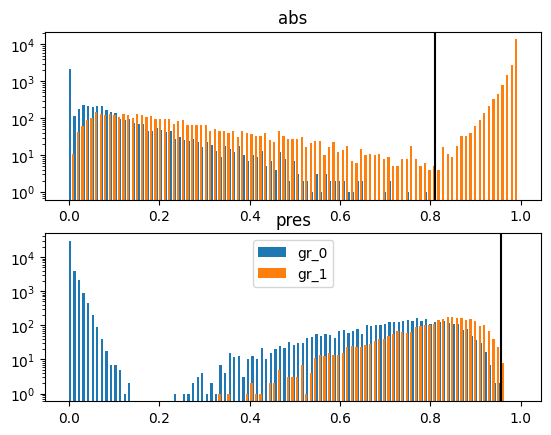

No improve counter : 0
item counter : 64
ratio : 0.0
 ratio number predicted/items: 311.3076923076923
current epoch: 0


/home/seb/Perso/git/sudoku/sudoku_clean_v2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('no_improve_counter', ...)` in your `on_validation_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/home/seb/Perso/git/sudoku/sudoku_clean_v2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

3.058953380584717 1.4525580167770387
3.058953380584717 1.4525580167770387
3.058953380584717 1.4525580167770387
3.058953380584717 1.4525580167770387
3.058953380584717 1.4525580167770387
3.058953380584717 2.2698455810546876
3.058953380584717 2.2698455810546876
3.058953380584717 2.2698455810546876
3.058953380584717 2.2698455810546876
3.058953380584717 2.2698455810546876
3.058953380584717 2.2698455810546876
3.058953380584717 2.2698455810546876
3.058953380584717 2.2698455810546876
3.058953380584717 2.2698455810546876
3.058953380584717 2.2698455810546876
3.058953380584717 2.2698455810546876
3.058953380584717 2.2698455810546876
3.058953380584717 2.2698455810546876
3.058953380584717 2.2698455810546876
3.058953380584717 2.2698455810546876
3.058953380584717 2.2698455810546876
3.058953380584717 2.2698455810546876
3.058953380584717 2.2698455810546876
3.058953380584717 2.2698455810546876
3.058953380584717 2.2698455810546876
3.058953380584717 2.2698455810546876
3.058953380584717 2.2698455810546876
3

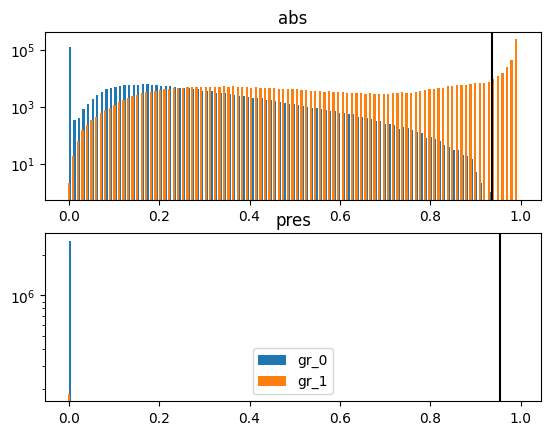

No improve counter : 1240
item counter : 3929
ratio : 0.3155216284987277
 ratio number predicted/items: 91.48625954198474
current epoch: 0


Validation: 0it [00:00, ?it/s]

3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3

3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477


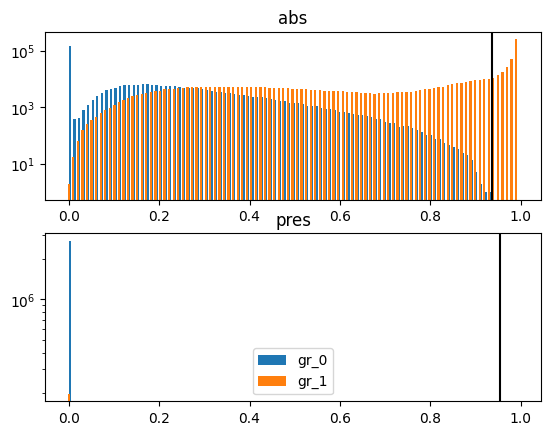

No improve counter : 1241
item counter : 4186
ratio : 0.29639359923572967
 ratio number predicted/items: 88.69954621447337
current epoch: 1


Validation: 0it [00:00, ?it/s]

3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3

3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3

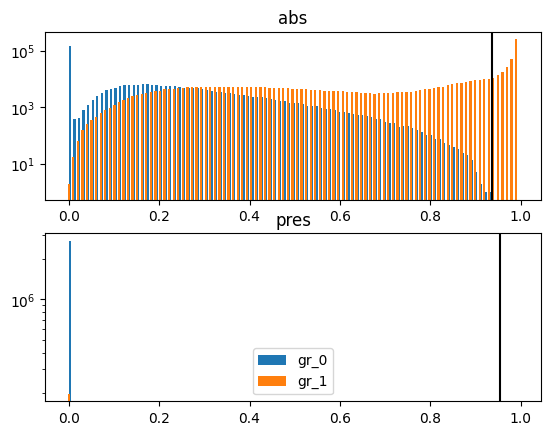

No improve counter : 1241
item counter : 4186
ratio : 0.29639359923572967
 ratio number predicted/items: 88.69954621447337
current epoch: 2


Validation: 0it [00:00, ?it/s]

3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3

3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477


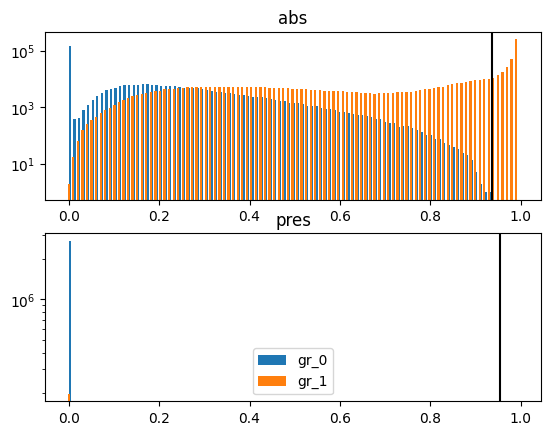

No improve counter : 1241
item counter : 4186
ratio : 0.29639359923572967
 ratio number predicted/items: 88.69954621447337
current epoch: 3


Validation: 0it [00:00, ?it/s]

3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3

3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477


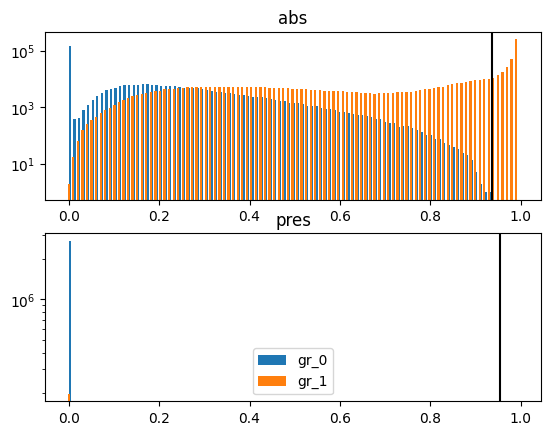

No improve counter : 1241
item counter : 4186
ratio : 0.29639359923572967
 ratio number predicted/items: 88.69954621447337
current epoch: 4
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.0589533

3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477


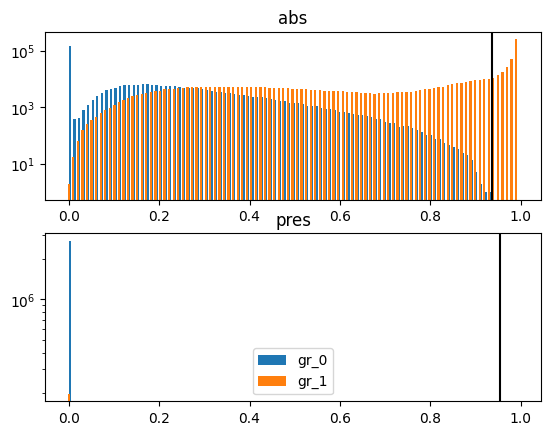

No improve counter : 1241
item counter : 4186
ratio : 0.29639359923572967
 ratio number predicted/items: 88.69954621447337
current epoch: 5


Validation: 0it [00:00, ?it/s]

3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3

3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3

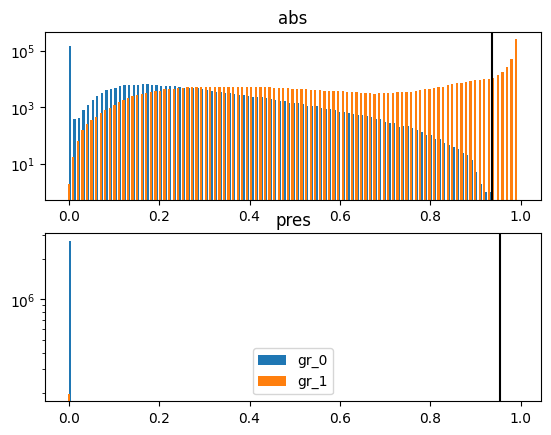

No improve counter : 1241
item counter : 4187
ratio : 0.29632282712511937
 ratio number predicted/items: 88.68051575931231
current epoch: 6


Validation: 0it [00:00, ?it/s]

3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3

3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477


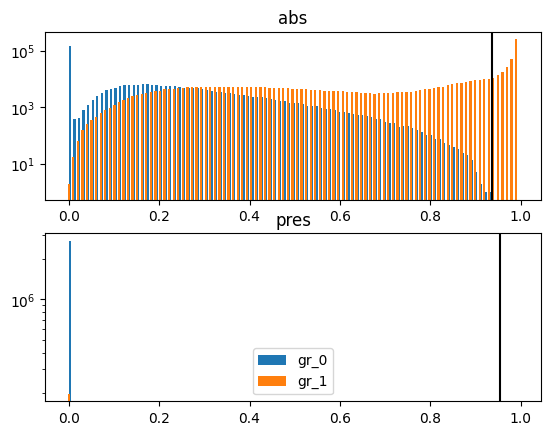

No improve counter : 1241
item counter : 4186
ratio : 0.29639359923572967
 ratio number predicted/items: 88.69954621447337
current epoch: 7


Validation: 0it [00:00, ?it/s]

3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3

3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477


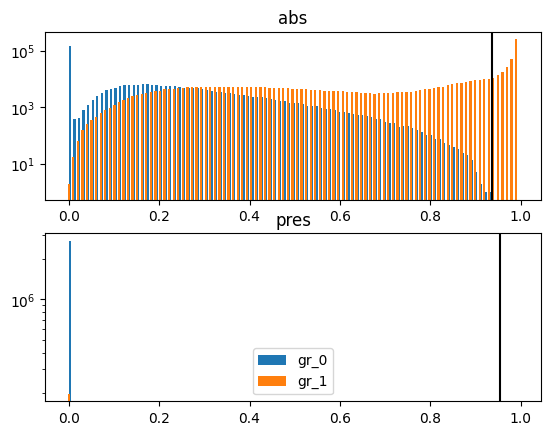

No improve counter : 1241
item counter : 4186
ratio : 0.29639359923572967
 ratio number predicted/items: 88.69954621447337
current epoch: 8


Validation: 0it [00:00, ?it/s]

3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3

3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477
3.058953380584717 2.6957117080688477


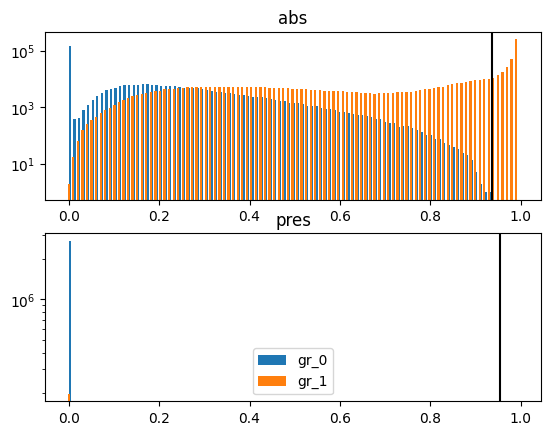

`Trainer.fit` stopped: `max_epochs=10` reached.


No improve counter : 1241
item counter : 4186
ratio : 0.29639359923572967
 ratio number predicted/items: 88.69954621447337
current epoch: 9


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/seb/Perso/git/sudoku/sudoku_clean_v2/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory lightning_logs/version_135/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params
-------------------------------------------------
0 | net        | SmallNet          | 514   
1 | bcewll     | BCEWithLogitsLoss | 0     
2 | auroc      | BinaryAUROC       | 0     
3 | prev_model | SmallNet          | 514   
-------------------------------------------------
1.0 K     Trainable params
0         Non-trainable params
1.0 K     Total params
0.004     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

-10 -10
3.6478014945983888 -1.2331152200698852
3.6478014945983888 -1.2331152200698852
3.6478014945983888 -0.8967133402824402


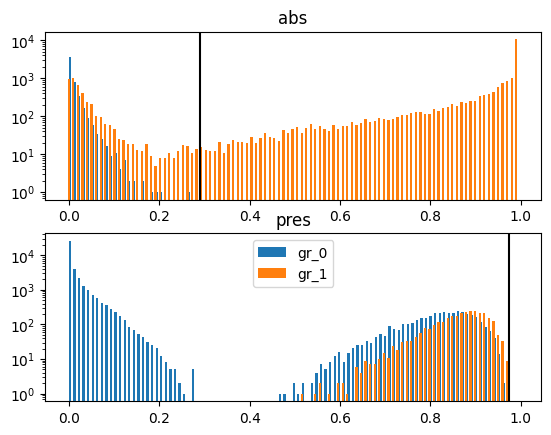

No improve counter : 0
item counter : 64
ratio : 0.0
 ratio number predicted/items: 309.6461538461538
current epoch: 0


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.896

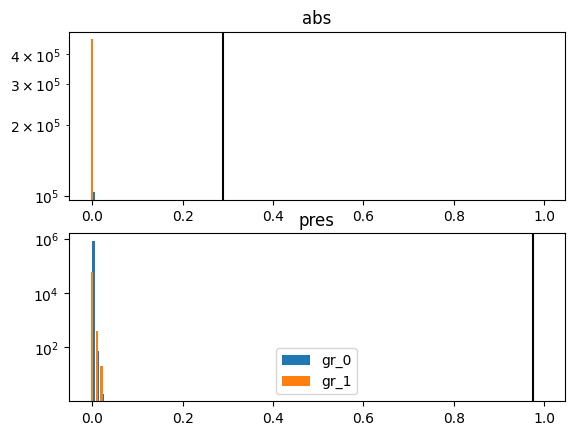

No improve counter : 1280
item counter : 1280
ratio : 0.9992193598750976
 ratio number predicted/items: 0.0
current epoch: 0


Validation: 0it [00:00, ?it/s]

3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.896

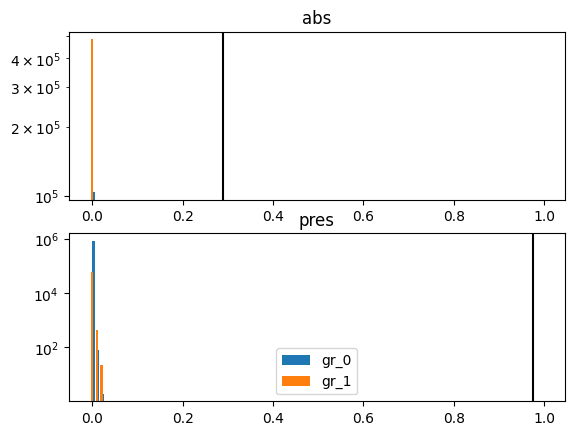

No improve counter : 1280
item counter : 1280
ratio : 0.9992193598750976
 ratio number predicted/items: 0.0
current epoch: 1


Validation: 0it [00:00, ?it/s]

3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.896

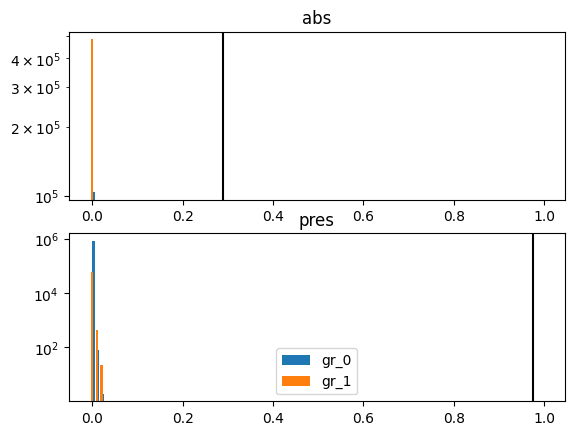

No improve counter : 1280
item counter : 1280
ratio : 0.9992193598750976
 ratio number predicted/items: 0.0
current epoch: 2


Validation: 0it [00:00, ?it/s]

3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.896

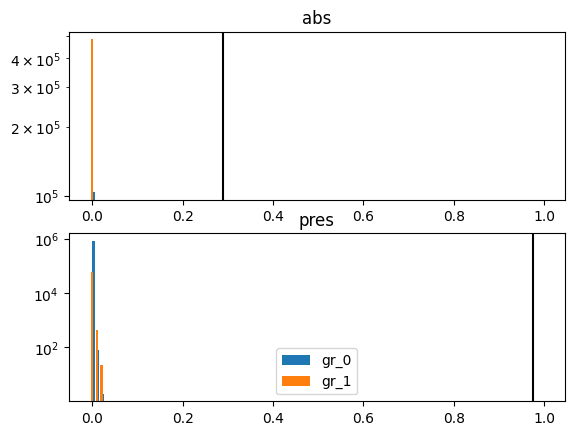

No improve counter : 1280
item counter : 1280
ratio : 0.9992193598750976
 ratio number predicted/items: 0.0
current epoch: 3


Validation: 0it [00:00, ?it/s]

3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.896

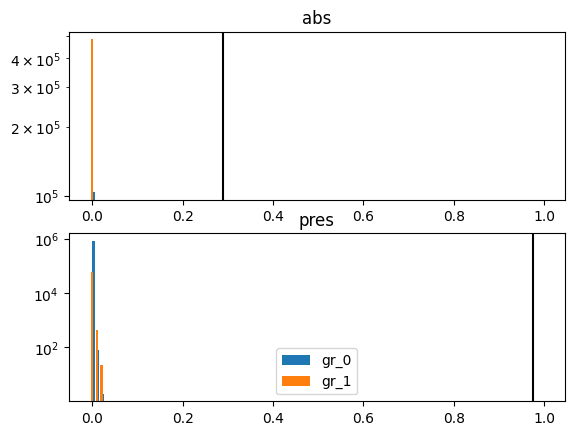

No improve counter : 1280
item counter : 1280
ratio : 0.9992193598750976
 ratio number predicted/items: 0.0
current epoch: 4


Validation: 0it [00:00, ?it/s]

3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.896

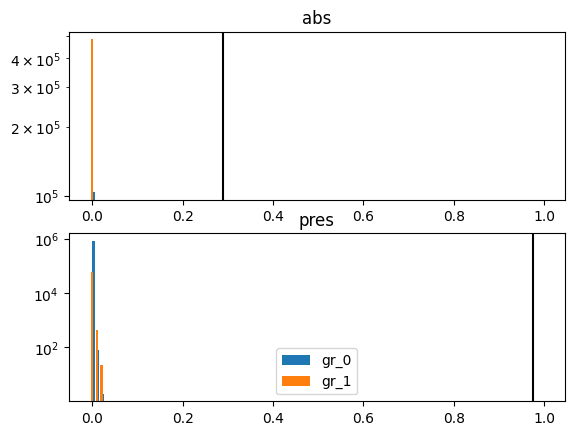

No improve counter : 1280
item counter : 1280
ratio : 0.9992193598750976
 ratio number predicted/items: 0.0
current epoch: 5


Validation: 0it [00:00, ?it/s]

3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.896

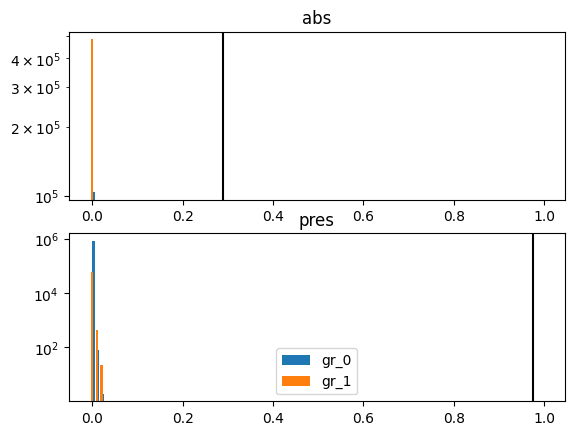

No improve counter : 1280
item counter : 1280
ratio : 0.9992193598750976
 ratio number predicted/items: 0.0
current epoch: 6


Validation: 0it [00:00, ?it/s]

3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.896

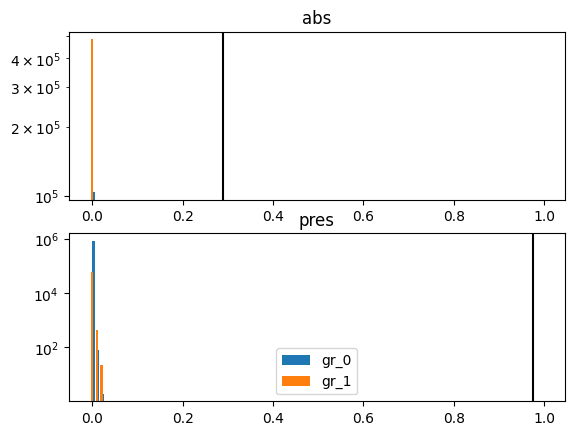

No improve counter : 1280
item counter : 1280
ratio : 0.9992193598750976
 ratio number predicted/items: 0.0
current epoch: 7


Validation: 0it [00:00, ?it/s]

3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.896

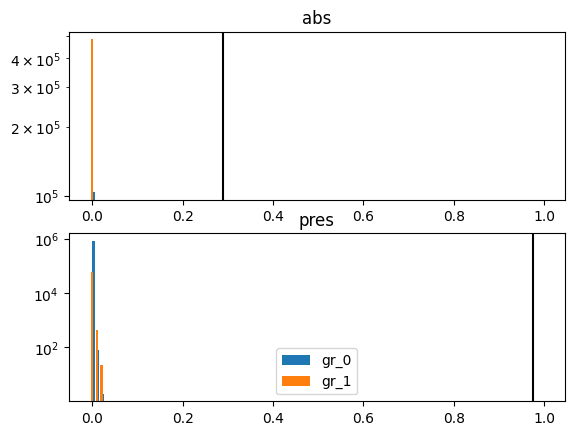

No improve counter : 1280
item counter : 1280
ratio : 0.9992193598750976
 ratio number predicted/items: 0.0
current epoch: 8


Validation: 0it [00:00, ?it/s]

3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.8967133402824402
3.6478014945983888 -0.896

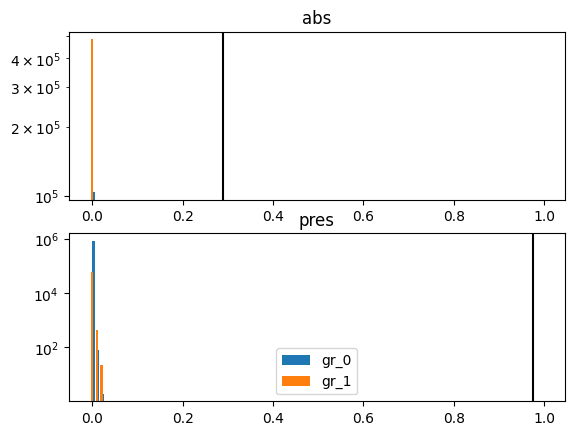

`Trainer.fit` stopped: `max_epochs=10` reached.


No improve counter : 1280
item counter : 1280
ratio : 0.9992193598750976
 ratio number predicted/items: 0.0
current epoch: 9


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params
-------------------------------------------------
0 | net        | SmallNet          | 514   
1 | bcewll     | BCEWithLogitsLoss | 0     
2 | auroc      | BinaryAUROC       | 0     
3 | prev_model | SmallNet          | 514   
-------------------------------------------------
1.0 K     Trainable params
0         Non-trainable params
1.0 K     Total params
0.004     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

-10 -10
5.131713008880615 -2.337795639038086
5.131713008880615 -2.337795639038086
5.131713008880615 -1.5593011617660522


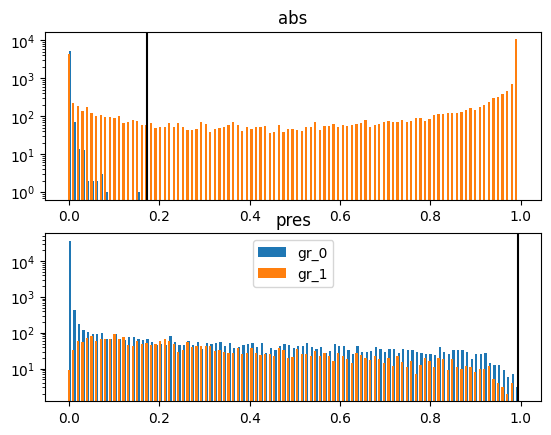

No improve counter : 0
item counter : 64
ratio : 0.0
 ratio number predicted/items: 284.4153846153846
current epoch: 0


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.1317130088

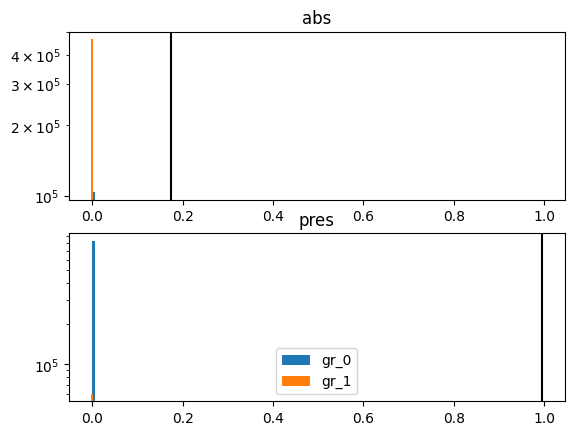

No improve counter : 1280
item counter : 1280
ratio : 0.9992193598750976
 ratio number predicted/items: 0.0
current epoch: 0


Validation: 0it [00:00, ?it/s]

5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.1317130088

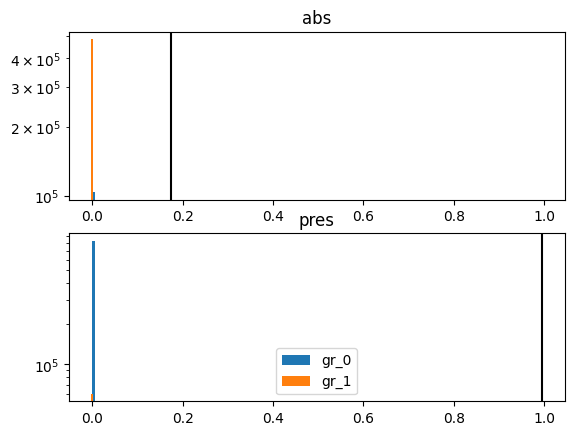

No improve counter : 1280
item counter : 1280
ratio : 0.9992193598750976
 ratio number predicted/items: 0.0
current epoch: 1


Validation: 0it [00:00, ?it/s]

5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.1317130088

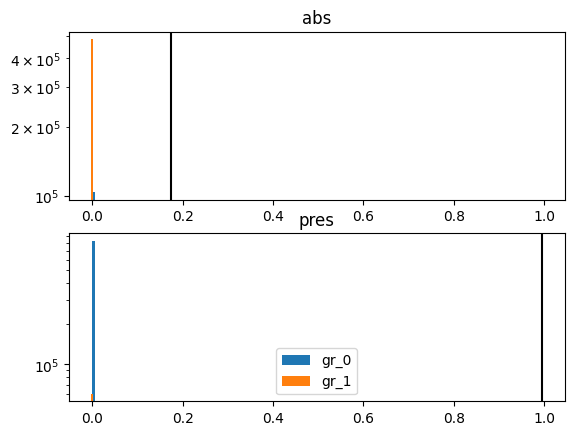

No improve counter : 1280
item counter : 1280
ratio : 0.9992193598750976
 ratio number predicted/items: 0.0
current epoch: 2


Validation: 0it [00:00, ?it/s]

5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.1317130088

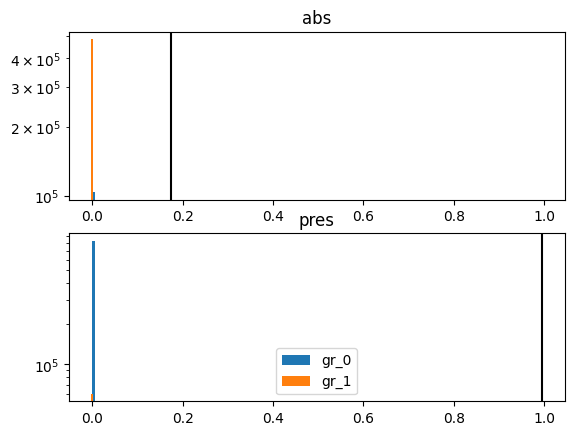

No improve counter : 1280
item counter : 1280
ratio : 0.9992193598750976
 ratio number predicted/items: 0.0
current epoch: 3


Validation: 0it [00:00, ?it/s]

5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.1317130088

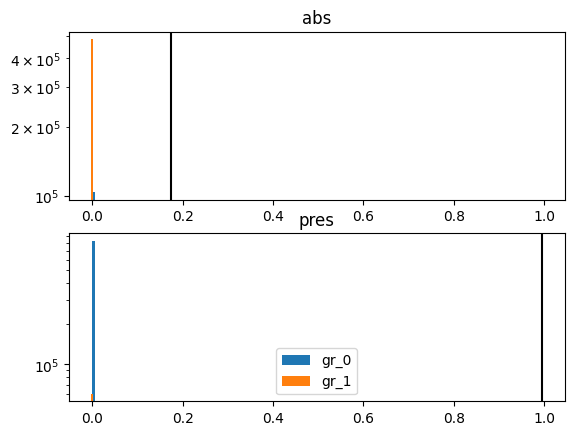

No improve counter : 1280
item counter : 1280
ratio : 0.9992193598750976
 ratio number predicted/items: 0.0
current epoch: 4


Validation: 0it [00:00, ?it/s]

5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.1317130088

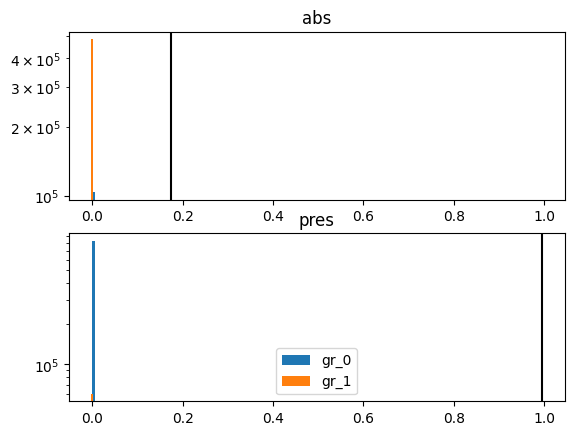

No improve counter : 1280
item counter : 1280
ratio : 0.9992193598750976
 ratio number predicted/items: 0.0
current epoch: 5


Validation: 0it [00:00, ?it/s]

5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.1317130088

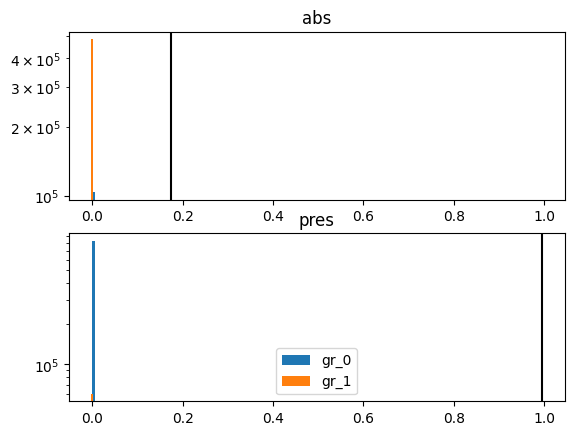

No improve counter : 1280
item counter : 1280
ratio : 0.9992193598750976
 ratio number predicted/items: 0.0
current epoch: 6


Validation: 0it [00:00, ?it/s]

5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.1317130088

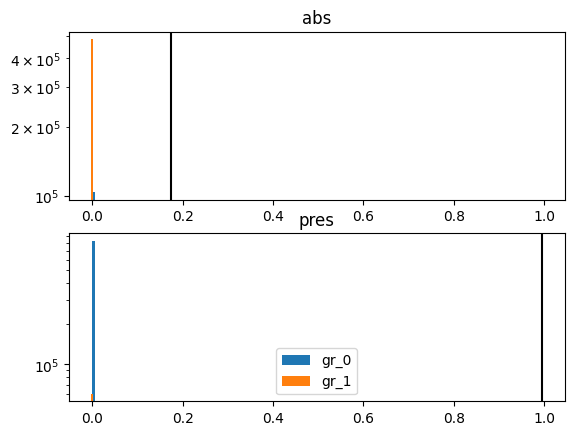

No improve counter : 1280
item counter : 1280
ratio : 0.9992193598750976
 ratio number predicted/items: 0.0
current epoch: 7


Validation: 0it [00:00, ?it/s]

5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.1317130088

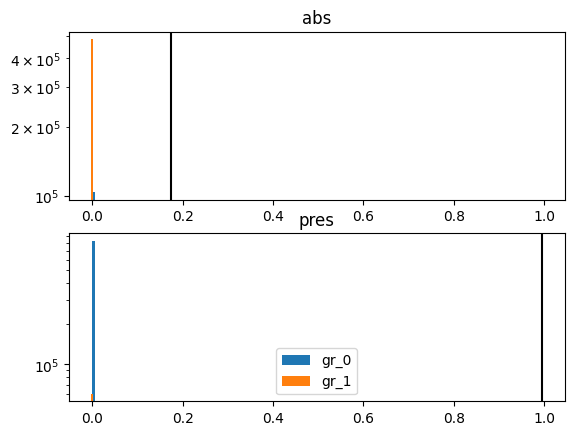

No improve counter : 1280
item counter : 1280
ratio : 0.9992193598750976
 ratio number predicted/items: 0.0
current epoch: 8


Validation: 0it [00:00, ?it/s]

5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.131713008880615 -1.5593011617660522
5.1317130088

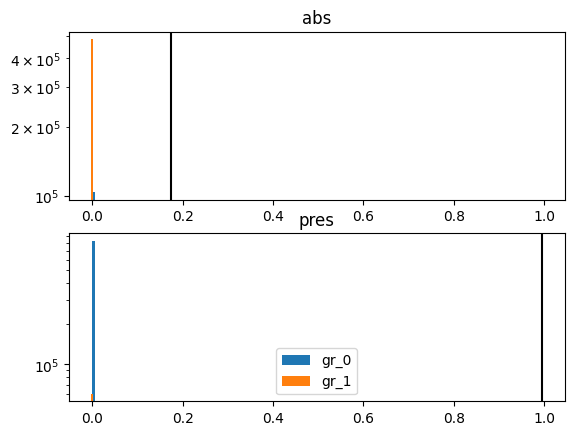

`Trainer.fit` stopped: `max_epochs=10` reached.


No improve counter : 1280
item counter : 1280
ratio : 0.9992193598750976
 ratio number predicted/items: 0.0
current epoch: 9


In [21]:
sym_preprocess.cuda()
new_prev_nets = []
for prev_net, (th_abs, th_pres) in prev_nets:
    model = StrengtheningMarge(prev_model=prev_net, th_abs=th_abs, th_pres=th_pres, prev_nets=new_prev_nets)
    model.net.load_state_dict(prev_net.state_dict())
    trainer = pl.Trainer(
    max_epochs=10,
    accelerator='gpu',
    devices=1,
    log_every_n_steps=1,
    # logger=pl.loggers.CSVLogger(save_dir="logs/"),
    reload_dataloaders_every_n_epochs=1,
    logger=tensorboard,
    )
    _ = trainer.fit(model,)
    new_prev_nets.append((model.net, (model.threshold_abs, model.threshold_pres)))
    del model
    del trainer
    pl.utilities.memory.garbage_collection_cuda()


In [ ]:
del model
del trainer
pl.utilities.memory.garbage_collection_cuda()

In [ ]:
len(new_prev_nets)

In [ ]:
# for i in range(3):
#     model_checkpoint = ModelCheckpoint(monitor='no_improve_counter')
#     trainer = pl.Trainer(
#     max_epochs=20,
#     accelerator='gpu',
#     devices=1,
#     log_every_n_steps=1,
#     # logger=pl.loggers.CSVLogger(save_dir="logs/"),
#     reload_dataloaders_every_n_epochs=1,
#     logger=tensorboard,
#     callbacks=[model_checkpoint]
#     )
#     print(i)
#     model = SudokuLightning(lr=0.01, prev_nets=prev_nets)
#     _ = trainer.fit(model,)
# #     model = model.load_from_checkpoint(model_checkpoint.best_model_path)
# #     trainer.validate(model=model)
#     prev_nets.append((model.net, (model.threshold_abs, model.threshold_pres)))

In [ ]:
trainer.callbacks[-1].best_model_path

In [ ]:
trainer.callbacks[-1].best_model_score

In [ ]:
prev_nets = prev_nets[:3]
len(prev_nets)

In [18]:
sym_preprocess.cpu()
def predict_from_net(x, net, th_abs, th_pres):
    x = sym_preprocess.forward(x)
    x = net(x)
    new_x = torch.empty(x.shape, device=x.device)
    new_x[:,0] = (x[:,0] > th_abs).float()
    new_x[:,1] = (x[:,1] > th_pres).float()
    return new_x

def forward_from_prev_nets(x,y):

    for net, (th_abs, th_pres) in prev_nets:
        new_x = torch.zeros(x.shape, device=x.device)
        with torch.no_grad():
            sub_new_x = predict_from_net(x, net.to(x.device), th_abs, th_pres)
        new_x[sub_new_x==1]=1
        new_x[x==1]=1
        print(f"errrors: {((new_x==1)&(y==0)).sum()}")
        new_x[(new_x==1)&(y==0)]=0
        if new_x.sum(dim=(1,2))>x.sum(dim=(1,2)):
            break
        x = new_x
    return new_x


def forward_from_prev_nets_all(x,y, prev_nets=prev_nets, raise_if_error=False):

    for i,(net, (th_abs, th_pres)) in enumerate(prev_nets):
        new_x = torch.zeros(x.shape, device=x.device)
        with torch.no_grad():
            sub_new_x = predict_from_net(x, net.to(x.device), th_abs, th_pres)
        new_x[sub_new_x==1]=1
        new_x[x==1]=1
        n_errors = ((new_x==1)&(y==0)).sum(dim=(0,2))
        
        # print(f"errrors: {n_errors}")
        if n_errors.sum()>0:
            print(f"found errors : {n_errors}")
            print(f"model index : {i}")
            if raise_if_error:
                raise ValueError
        new_x[(new_x==1)&(y==0)]=0
        x = new_x
    return new_x

def fix_threshold(x,y,prev_nets, margin=0.05):
    x_feature = sym_preprocess.forward(x)
    new_prev_nets = []
    for net, (th_abs, th_pres) in prev_nets:
        
        output = net(x_feature)       
        max_th_abs = output[:,0][(x[:,0]==0)&(y[:,0]==0)].max().item()
        print(max_th_abs)
        if th_abs < max_th_abs+margin:
            th_abs = max_th_abs+margin
        max_th_pres = output[:,1][(x[:,1]==0)&(y[:,1]==0)].max().item()
        print(max_th_pres)
        if th_pres < max_th_pres+margin:
            th_pres = max_th_pres+margin  
        new_prev_nets.append((net, (th_abs, th_pres)))
    return new_prev_nets

In [25]:
print(test_x.sum())
print(test_x[:,1].sum())
display_as_dataframe(test_x)

tensor(234.)
tensor(26.)


In [26]:
new_x = forward_from_prev_nets_all(test_x, test_y)
print(new_x.sum())
print(new_x[:,1].sum())
display_as_dataframe(new_x)

tensor(561.)
tensor(32.)


In [27]:
prev_x = new_x.clone()
new_x = forward_from_prev_nets_all(new_x, test_y)
print(new_x.sum())
print(new_x[:,1].sum())
display_as_dataframe(new_x)

tensor(584.)
tensor(34.)


In [28]:
new_x = forward_from_prev_nets_all(new_x, test_y)
print(new_x.sum())
print(new_x[:,1].sum())
display_as_dataframe(new_x)

tensor(591.)
tensor(35.)


In [29]:
new_x = forward_from_prev_nets_all(new_x, test_y)
print(new_x.sum())
print(new_x[:,1].sum())
display_as_dataframe(new_x)

tensor(597.)
tensor(35.)


In [30]:
new_x = forward_from_prev_nets_all(new_x, test_y)
print(new_x.sum())
print(new_x[:,1].sum())
display_as_dataframe(new_x)

tensor(597.)
tensor(35.)


In [ ]:
new_x = forward_from_prev_nets_all(new_x, test_y)
print(new_x.sum())
print(new_x[:,1].sum())
display_as_dataframe(new_x)

In [ ]:
new_x = forward_from_prev_nets_all(new_x, test_y)
print(new_x.sum())
print(new_x[:,1].sum())
display_as_dataframe(new_x)

In [ ]:
print(test_x.sum())
print(test_x[:,1].sum())
display_as_dataframe(test_x)

In [ ]:
new_x = forward_from_prev_nets_all(test_x, test_y, prev_nets=new_prev_nets)
print(new_x.sum())
print(new_x[:,1].sum())
display_as_dataframe(new_x)

In [ ]:
prev_x = new_x.clone()
new_x = forward_from_prev_nets_all(new_x, test_y, prev_nets=new_prev_nets)
print(new_x.sum())
print(new_x[:,1].sum())
display_as_dataframe(new_x)

In [ ]:
new_x = forward_from_prev_nets_all(new_x, test_y, prev_nets=new_prev_nets)
print(new_x.sum())
print(new_x[:,1].sum())
display_as_dataframe(new_x)

In [ ]:
new_x = forward_from_prev_nets_all(new_x, test_y, prev_nets=new_prev_nets)
print(new_x.sum())
print(new_x[:,1].sum())
display_as_dataframe(new_x)

In [ ]:
new_x = forward_from_prev_nets_all(new_x, test_y, prev_nets=new_prev_nets)
print(new_x.sum())
print(new_x[:,1].sum())
display_as_dataframe(new_x)

In [31]:
from sudoku.loader import get_datasets
from tqdm.notebook import tqdm

In [32]:
train, test = get_datasets(train_size=5000, test_size=5000)

In [34]:
for x,y in tqdm(train):
    x = x.view(1,2,729)
    y = y.view(1,2,729)
    
    while (x!=y).any():
        new_x = forward_from_prev_nets_all(x, y, raise_if_error=False, prev_nets=prev_nets)
        if (new_x == x).all():
            print("No improvment")
            raise ValueError
            break
        x = new_x

  0%|          | 0/5000 [00:00<?, ?it/s]

found errors : tensor([0, 2])
model index : 1
found errors : tensor([0, 1])
model index : 1
No improvment


ValueError: 

In [ ]:
display_as_dataframe(x)

In [ ]:
for x,y in tqdm(train):
    x = x.view(1,2,729)
    y = y.view(1,2,729)
    
    while (x!=y).any():
        new_x = forward_from_prev_nets_all(x, y, raise_if_error=False,prev_nets=new_prev_nets)
        if (new_x == x).all():
            print("No improvment")
            raise ValueError
            break
        x = new_x

In [ ]:
for x,y in tqdm(train):
    x = x.view(1,2,729)
    y = y.view(1,2,729)
    
    while (x!=y).any():
        new_x = forward_from_prev_nets_all(x, y, raise_if_error=True, prev_nets=new_prev_nets)
        if (new_x == x).all():
            print("No improvment")
            raise ValueError
            break
        x = new_x

In [ ]:
new_prev_nets

In [ ]:
new_prev_nets = fix_threshold(x,y,new_prev_nets)

In [ ]:
new_prev_nets

In [ ]:
for x,y in tqdm(train):
    x = x.view(1,2,729)
    y = y.view(1,2,729)
    
    while (x!=y).any():
        new_x = forward_from_prev_nets_all(x, y, raise_if_error=True, prev_nets=new_prev_nets)
        if (new_x == x).all():
            print("No improvment")
            raise ValueError
            break
        x = new_x

In [ ]:
new_prev_nets = fix_threshold(x,y,prev_nets)

In [ ]:
for x,y in tqdm(train):
    x = x.view(1,2,729)
    y = y.view(1,2,729)
    
    while (x!=y).any():
        new_x = forward_from_prev_nets_all(x, y, raise_if_error=True,prev_nets=new_prev_nets)
        if (new_x == x).all():
            print("No improvment")
            raise ValueError
        x = new_x

In [ ]:
prev_nets=new_prev_nets

In [ ]:
model_checkpoint = ModelCheckpoint(monitor='ratio_number_predicted_per_items', mode='max')
trainer = pl.Trainer(
max_epochs=20,
accelerator='gpu',
devices=1,
log_every_n_steps=1,
# logger=pl.loggers.CSVLogger(save_dir="logs/"),
reload_dataloaders_every_n_epochs=1,
logger=tensorboard,
callbacks=[model_checkpoint]
)
model = SudokuLightning(lr=0.01, prev_nets=prev_nets, )
_ = trainer.fit(model,)
#     model = model.load_from_checkpoint(model_checkpoint.best_model_path)
#     print(model_checkpoint.best_model_path)
#     trainer.validate(model=model)
#     if trainer.logged_metrics['no_improve_counter'].item()==0:
prev_nets.append((model.net, (model.threshold_abs, model.threshold_pres)))

In [ ]:
new_x = forward_from_prev_nets_all(new_x, y)

In [ ]:
new_x.sum(dim=(0,2))

In [ ]:
model_checkpoint = ModelCheckpoint(monitor='no_improve_counter')
trainer = pl.Trainer(
max_epochs=20,
accelerator='gpu',
devices=1,
log_every_n_steps=1,
# logger=pl.loggers.CSVLogger(save_dir="logs/"),
reload_dataloaders_every_n_epochs=1,
logger=tensorboard,
callbacks=[model_checkpoint]
)
print(i)
model = SudokuLightning(lr=0.01, prev_nets=prev_nets)
_ = trainer.fit(model,)
#     model = model.load_from_checkpoint(model_checkpoint.best_model_path)
#     trainer.validate(model=model)
prev_nets.append((model.net, (model.threshold_abs, model.threshold_pres)))